In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from geopy import distance
import pickle
from utils_dump_load import load_from_pickle, dump_to_pickle

<h1> Data description

The training dataset provided here is a subset of over 20,000 orders and only includes direct orders (i.e. Sendy “express” orders) with bikes in Nairobi

In [2]:
pd.set_option('display.max_columns', 40)

<h1> Loading Data

<h2> Test Dataframe

In [3]:
filepath_test = "data/Test.csv"
df_test = pd.read_csv(filepath_test, index_col="Order No")
df_test.shape

(7068, 24)

In [4]:
df_test["Vehicle Type"].unique()

array(['Bike'], dtype=object)

<h2> Train Dataframe

In [5]:
filepath_train = "data/Train.csv"
df_train = pd.read_csv(filepath_train, index_col="Order No")
df_train.shape

(21201, 28)

In [6]:
df_train.head()

,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
Order No,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


<h2> Riders Dataframe

In [7]:
pickle_filename = "data/riders.pkl"
df_riders = load_from_pickle(pickle_filename)

<h2> Merges

In [8]:
df_train = df_train.merge(df_riders, left_on='Rider Id', right_on='Rider Id', right_index=True)
df_test = df_test.merge(df_riders, left_on='Rider Id', right_on='Rider Id', right_index=True)

<h1> Feature engineering

In [9]:
steps = ["Placement", "Confirmation", "Arrival at Pickup", "Pickup"]

- Vehicule type can be dropped ? -> Yes no other Vehicule type in test folder
- Used_id and Rider_id would be dropped as well as first approach

<h2> Business / Personal

- "Personal or Business": 1 - Business / 0 - Personal

In [10]:
df_train["Personal or Business"][df_train["Personal or Business"] == 'Business'] = 1
df_train["Personal or Business"][df_train["Personal or Business"] == 'Personal'] = 0

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/zyncus/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
df_test["Personal or Business"][df_test["Personal or Business"] == 'Business'] = 1
df_test["Personal or Business"][df_test["Personal or Business"] == 'Personal'] = 0

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/zyncus/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<h2> Pickup Hour

In [12]:
def get_hour(x):
    datetime_object = datetime.strptime(x, "%I:%M:%S %p")
    return datetime_object.hour

In [13]:
df_train["Pickup - Hour"] = df_train["Pickup - Time"].apply(lambda x: get_hour(x))
df_test["Pickup - Hour"] = df_test["Pickup - Time"].apply(lambda x: get_hour(x))

<h2> Filling Precipitations

In [15]:
mean_temps = df_train.groupby("Pickup - Hour")["Temperature"].mean()
mean_rains = df_train.groupby("Pickup - Hour")["Precipitation in millimeters"].mean()
mean_rains.fillna(method="ffill", inplace=True)
mean_rains[0] = mean_rains[23]

In [16]:
def fill_rains(precip, hour):
    if np.isnan(precip):
        return mean_rains[hour]
    else:
        return precip

In [17]:
df_train["Precipitation in millimeters"] = df_train.apply(lambda x: fill_rains(x["Precipitation in millimeters"], x["Pickup - Hour"]), axis=1)
df_test["Precipitation in millimeters"] = df_test.apply(lambda x: fill_rains(x["Precipitation in millimeters"], x["Pickup - Hour"]), axis=1)

<h2> Filling Temperature

Not needed anymore as we  filled the missing temperature with a XGBoost regressor.

In [16]:
def fill_temps(precip, hour):
    if np.isnan(precip):
        return mean_temps[hour]
    else:
        return precip

In [17]:
df_train["Temperature"] = df_train.apply(lambda x: fill_temps(x["Temperature"], x["Pickup - Hour"]), axis=1)
df_test["Temperature"] = df_test.apply(lambda x: fill_temps(x["Temperature"], x["Pickup - Hour"]), axis=1)

<h2> Weekend feature

In [18]:
def weekend(x):
    if x in [5, 6, 7]:
        return 1
    else:
        return 0

In [19]:
for step in steps:
    feature_name = step + " - " + "Weekday (Mo = 1)"
    new_feature = step + " - Weekend"
    df_train[new_feature] = df_train[feature_name].apply(lambda x: weekend(x))
    df_test[new_feature] = df_test[feature_name].apply(lambda x: weekend(x))

<h2> Datetime and Timelaps between steps

In [20]:
example = df_train["Placement - Time"].values[7]
example

'4:12:56 PM'

In [21]:
ref_datetime = datetime(1900, 1, 1, 0, 0, 0)
datetime_object = datetime.strptime(example, "%I:%M:%S %p")
delta = datetime_object - ref_datetime
delta.total_seconds()

58376.0

In [22]:
def get_timestamp(x):
    datetime_object = datetime.strptime(x, "%I:%M:%S %p")
    delta = datetime_object - ref_datetime
    return delta.total_seconds()

In [23]:
for step in steps:
    feature_name = step + " - " + "Time"
    df_train[feature_name] = df_train[feature_name].apply(lambda x: get_timestamp(x))
    df_test[feature_name] = df_test[feature_name].apply(lambda x: get_timestamp(x))

In [24]:
df_train["Arrival at Destination - Time"] = df_train["Arrival at Destination - Time"].apply(lambda x: get_timestamp(x))

<h2> Adding delta time between steps

In [25]:
for i in range(len(steps)):
    if i < len(steps)-1:
        step1 = steps[i] + " - " + "Time"
        step2 = steps[i+1] + " - " + "Time"
        new_feature = steps[i] + " - " + "Delta"
        df_train[new_feature] = df_train.apply(lambda x: x[step2] - x[step1], axis=1)
        df_test[new_feature] = df_test.apply(lambda x: x[step2] - x[step1], axis=1)

<h2> Compute geopy distance

In [26]:
def compute_distance(row):
    src = (row["Pickup Lat"],row["Pickup Long"])
    dest= (row["Destination Lat"],row["Destination Long"])
    return distance.distance(src,dest).km

In [27]:
df_train["geopy_distance"] = df_train.apply(compute_distance,axis=1)
df_test["geopy_distance"] = df_test.apply(compute_distance,axis=1)

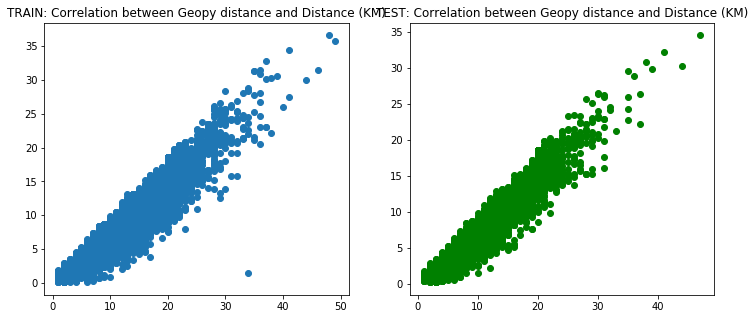

In [28]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.scatter(df_train["Distance (KM)"], df_train["geopy_distance"])
plt.title("TRAIN: Correlation between Geopy distance and Distance (KM)")


plt.subplot(1, 2, 2)
plt.scatter(df_test["Distance (KM)"], df_test["geopy_distance"], c="g")
plt.title("TEST: Correlation between Geopy distance and Distance (KM)")

plt.show()

<h2> Distance mean

In [29]:
df_train["Distance mean"] = (df_train["Distance (KM)"] + df_train["geopy_distance"])/2
df_test["Distance mean"] = (df_test["Distance (KM)"] + df_test["geopy_distance"])/2

<h2> Cleaning User_id and Rider_id

In [30]:
def clean(x, post):
    return x.replace(post, "")

In [31]:
df_train["User Id"] = df_train["User Id"].apply(lambda x: clean(x, "User_Id_"))
df_train["Rider Id"] = df_train["Rider Id"].apply(lambda x: clean(x, "Rider_Id_"))

In [32]:
df_test["User Id"] = df_test["User Id"].apply(lambda x: clean(x, "User_Id_"))
df_test["Rider Id"] = df_test["Rider Id"].apply(lambda x: clean(x, "Rider_Id_"))

<h2> Change type of columns

In [33]:
cols_to_exclude = ["Distance (KM)", "Temperature", "Precipitation in millimeters", "Age", "No_of_Ratings", "No_Of_Orders", "Average_Rating", "speed"]

cols_to_include = ["User Id", "Rider Id"]

def change_types(df):
    for column in df.columns:
        if df[column].nunique() < 600 and column not in cols_to_exclude or column in cols_to_include:
            df[column] = df[column].astype("category")
        elif df[column].nunique() > 600 and column not in cols_to_include or column in cols_to_exclude:
            df[column] = df[column].astype("float")

In [34]:
change_types(df_train)
change_types(df_test)

In [35]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Placement - Time,7068.0,46070.314233,9099.289717,23647.000000,38775.750000,45642.500000,53248.000000,80000.000000
Confirmation - Time,7068.0,46502.064941,9140.389270,24454.000000,39073.750000,46084.000000,53740.000000,80350.000000
Arrival at Pickup - Time,7068.0,47277.052207,9152.194703,26227.000000,39938.250000,46918.000000,54519.250000,82430.000000
Pickup - Time,7068.0,48012.340266,9130.459177,26289.000000,40656.500000,47662.000000,55296.500000,84058.000000
Distance (KM),7068.0,9.458970,5.575689,1.000000,5.000000,8.000000,13.000000,47.000000
Temperature,7068.0,23.216958,3.342323,13.200000,20.872080,23.300000,25.400103,32.100000
Precipitation in millimeters,199.0,6.651759,14.085439,0.100000,1.100000,2.900000,4.950000,99.100000
Pickup Lat,7068.0,-1.282043,0.030044,-1.433512,-1.301201,-1.281301,-1.257274,-1.148352
Pickup Long,7068.0,36.811148,0.037962,36.653828,36.784605,36.807219,36.829716,36.991046
Destination Lat,7068.0,-1.282255,0.034236,-1.422652,-1.300921,-1.283219,-1.261256,-1.030225


In [36]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Placement - Time,21201.0,46182.663695,9090.211849,436.000000,38806.000000,45836.000000,53425.000000,82021.000000
Confirmation - Time,21201.0,46615.894816,9139.332233,515.000000,39189.000000,46272.000000,53904.000000,82762.000000
Arrival at Pickup - Time,21201.0,47392.416254,9146.488556,731.000000,39937.000000,47057.000000,54645.000000,83400.000000
Pickup - Time,21201.0,48136.602660,9131.670601,2992.000000,40682.000000,47826.000000,55384.000000,83621.000000
Arrival at Destination - Time,21201.0,49693.523607,9196.430890,2997.000000,42191.000000,49404.000000,56949.000000,83996.000000
Distance (KM),21201.0,9.506533,5.668963,1.000000,5.000000,8.000000,13.000000,49.000000
Temperature,21201.0,23.249017,3.355284,11.200000,20.872080,23.500000,25.400103,32.100000
Precipitation in millimeters,552.0,7.905797,17.089971,0.100000,1.075000,2.900000,4.900000,99.100000
Pickup Lat,21201.0,-1.281470,0.030507,-1.438302,-1.300921,-1.279395,-1.257147,-1.147170
Pickup Long,21201.0,36.811264,0.037473,36.653621,36.784605,36.807040,36.829741,36.991046


<h2> Checking of time between Pickup and Time delta

In [37]:
from sklearn.metrics import accuracy_score, mean_squared_error

In [38]:
y_delta = df_train["Arrival at Destination - Time"] - df_train["Pickup - Time"]

In [39]:
y = df_train["Time from Pickup to Arrival"]

In [40]:
accuracy_score(y, y_delta)

1.0

<h2> No short duration into X_train

Building a specific training dataset with NO short duration duration

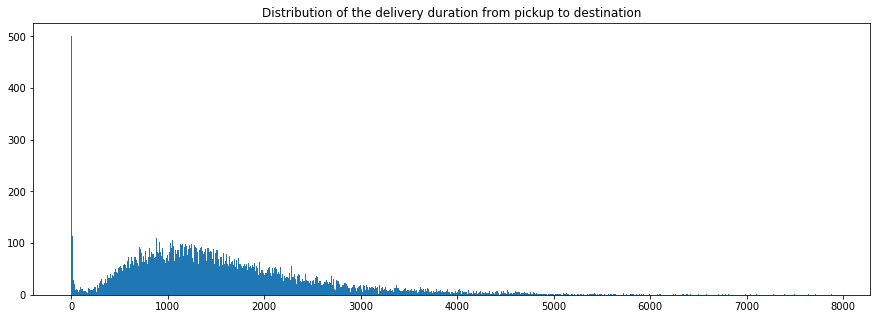

In [41]:
plt.figure(figsize=(15,5))
plt.hist(y, bins=1000)
plt.title("Distribution of the delivery duration from pickup to destination")
plt.show()

In [42]:
y[y<10].sum(), y[y>40][y<50].sum()

(2054.0, 501.0)

<h2> Dump to pickle file

In [43]:
df_train.shape, df_test.shape

((21201, 48), (7068, 44))

In [44]:
pickle_filename = "data/data.pkl"
content = (df_train, df_test)
dump_to_pickle(content, pickle_filename)

<h1> to be improved

- API calls -> Check route with lat and long between pickup and arival
- Uber data for traffic

- Scalling data ?
- Adding delta time instead of timelapse ?
- Get dummies ?